## Æther: Plagiarism Detection Model

This notebook presents a comprehensive approach to source code plagiarism detection using machine learning techniques. The system leverages code embeddings from pre-trained models combined with neural networks to identify similar code fragments with high accuracy.

## Introduction

Source code plagiarism detection is a significant challenge in academic environments and industry. This notebook implements a plagiarism detection system for Java source code by comparing code embeddings generated from a pre-trained model (CodeBERTa). The approach involves extracting semantic representations of code and using neural networks to determine similarity.


## 1.0 Environment Setup

The notebook begins by setting up the necessary environment, including importing required libraries and verifying GPU availability.


In [29]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from typing import Optional

### 1.1 Seed Configuration


In [30]:
np.random.seed(42)
torch.manual_seed(42)

### 1.2 GPU Support


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 1.3 Model Configuration

The model leverages the HuggingFace Transformers library to load pre-trained models for code representations.


In [32]:
tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
embedding_model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to(device)

## 2.0 Data Loading and Preprocessing


In [33]:
def load_dataset(datasets: list[tuple[str, str]]):
    """
    Load and preprocess dataset efficiently by reading unique files once.

    This function loads plagiarism detection datasets by reading the label files
    and associated source files. It optimizes performance by loading each
    unique file once.

    Args:
        datasets (list[tuple[str, str]]): List of tuples containing paths to
            labels and their corresponding base directories with source files.

    Returns:
        pandas.DataFrame: DataFrame containing processed data with columns:
            - id1, id2: Identifiers for file pairs
            - plagio: Binary label indicating plagiarism
            - file1, file2: Actual content of the source code files

    Raises:
        FileNotFoundError: If label file or base directory doesn't exist
    """

    columns = ["id1", "id2", "plagio", "file1", "file2"]
    df = pd.DataFrame(columns=columns)

    for labels_path, base_dir in datasets:
        labels_path = Path(labels_path)
        base_dir = Path(base_dir)

        if not labels_path.exists() or not labels_path.is_file():
            raise FileNotFoundError(f"Labels file not found: {labels_path}")

        if not base_dir.exists() or not base_dir.is_dir():
            raise FileNotFoundError(f"Base directory not found: {base_dir}")

        df2 = pd.read_csv(labels_path)

        df2["id1"] = df2["id1"].astype(str)
        df2["id2"] = df2["id2"].astype(str)
        df2["plagio"] = df2["plagio"].astype(int)

        unique_ids = pd.concat([df2["id1"], df2["id2"]]).unique()

        files = {}
        for file_id in tqdm(unique_ids, desc="Loading files"):
            path = base_dir / f"{file_id}.java"

            if path.exists():
                try:
                    files[file_id] = path.read_text(encoding="utf-8")

                except UnicodeDecodeError:
                    files[file_id] = path.read_text(encoding="latin-1")

            else:
                raise FileNotFoundError(f"File not found: {path}")

        df2["file1"] = df2["id1"].map(files)
        df2["file2"] = df2["id2"].map(files)

        df = pd.concat([df, df2[columns]], ignore_index=True)

    return df

## 3.0 Embedding Functions


In [34]:
def embed_batch(texts: str, batch_size: int = 16) -> np.ndarray:
    """
    Efficiently embed multiple text samples in batches.

    This function processes code snippets through the CodeBERTa model
    to generate embeddings. It optimizes memory usage be processing in
    batches and minimizing GPU transfers.

    Args:
        texts (list): List of text strings to embed
        batch_size (int, optional): Number of texts to process in each batch.
                                    Defaults to 16.

    Returns:
        numpy.ndarray: Array of embeddings, shape (len(texts), embedding_dim)
    """

    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(
            batch_texts, padding="longest", truncation=True, return_tensors="pt"
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = embedding_model(**inputs)

        embeddings = outputs.pooler_output
        all_embeddings.append(embeddings.cpu().numpy())

    return np.vstack(all_embeddings) if all_embeddings else np.array([])

In [35]:
def embed(text: str) -> np.ndarray:
    """
    Embed a single text input.

    This function processes a single code snippet through the CodeBERTa model
    to generate an embedding vector.

    Args:
      text (str): Text string to embed

    Returns:
      numpy.ndarray: Embedding vector.
    """

    inputs = tokenizer(text, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = embedding_model(**inputs)

    embeddings = torch.mean(outputs.last_hidden_state, dim=1)[0]
    return embeddings.cpu().numpy()

In [36]:
def embed_dataset(dataset: Dataset) -> Dataset:
    """
    Process dataset by embedding all unique files only once.

    This function optimizes the embedding process by identifying unique
    files, embedding them once, and then mapping the embeddings to all
    occurrences in the dataset.

    Args:
        dataset (datasets.Dataset): Input dataset containing code files

    Returns:
        datasets.Dataset: Original dataset augmented with embedding vectors
    """

    all_files = []
    file_to_idx = {}

    unique_files = set()
    for file1, file2 in zip(dataset["file1"], dataset["file2"]):
        unique_files.add(file1)
        unique_files.add(file2)

    all_files = list(unique_files)
    file_to_idx = {file: idx for idx, file in enumerate(all_files)}

    print(f"Embedding {len(all_files)} unique files...")

    all_embeddings = embed_batch(all_files, 128)
    file_to_embedding = {file: all_embeddings[idx] for file, idx in file_to_idx.items()}

    def add_embeddings(example):
        return {
            "embeddedFile1": file_to_embedding[example["file1"]],
            "embeddedFile2": file_to_embedding[example["file2"]],
        }

    return dataset.map(add_embeddings)

## 4.0 Model Evaluation


In [37]:
def find_optimal_threshold(y_true: np.ndarray, y_scores: np.ndarray) -> float:
    """Find the optimal classification threshold using ROC curve

    Determines the optimal decision threshold by maximizing the
    difference between true positive rate and false positive rate.

    Args:
        y_true (np.ndarray): Ground truth binary labels
        y_scores (np.ndarray): Predicted scores or probabilities

    Returns:
        float: Optimal threshold value for binary classification
    """

    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [38]:
def evaluate_model(
    df: pd.DataFrame,
    threshold: Optional[float] = None,
):
    """
    Evaluate model performance and generate visualizations.

    This function evaluates a plagiarism detection model using various metrics,
    visualizes the confusion matrix, and displays the distribution of similarity scores.
    If no threshold is provided, it finds the optimal threshold automatically.

    Args:
        df (DataFrame): DataFrame containing 'plagio' (true labels) and
                        'similarity' (predictions)
        threshold (float, optional): Classification threshold. If None, optimal
                                     threshold is computed.

    Returns:
        None: Displays classification report, confusion matrix,
              and score distribution
    """

    if threshold is None:
        threshold = find_optimal_threshold(
            df["plagio"].values,
            df["similarity"].values,
        )
        print(f"Optimal threshold: {threshold:.2f}")

    df["predicted"] = df["similarity"].apply(lambda x: 1 if x > threshold else 0)

    report = classification_report(df["plagio"], df["predicted"])
    print(report)
    cm = confusion_matrix(df["plagio"], df["predicted"])

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Not Plagiarized", "Plagiarized"]
    )
    disp.plot(
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=plt.gca(),
    )
    plt.title("Confusion Matrix")
    plt.show()

    # Plot the distribution of the similarity scores
    plt.figure(figsize=(10, 7))
    plt.hist(
        df["similarity"], bins=50, alpha=0.7, color="blue", label="Similarity Scores"
    )
    plt.axvline(threshold, color="red", linestyle="--")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Similarity Scores")
    plt.show()

## 5.0 Loading the Datasets


In [39]:
LABELS_PATH = Path("../labels")
CONPLAG_LABEL_PATH = LABELS_PATH / "conplag_labels.csv"
IR_PLAG_LABEL_PATH = LABELS_PATH / "ir_plag_labels.csv"

In [40]:
BASE_DIR = Path("../datasets")
CONPLAG_BASE_DIR = BASE_DIR / "conplag_preprocessed"
IR_PLAG_BASE_DIR = BASE_DIR / "ir_plag_preprocessed"

In [41]:
df2 = load_dataset(
    [(CONPLAG_LABEL_PATH, CONPLAG_BASE_DIR), (IR_PLAG_LABEL_PATH, IR_PLAG_BASE_DIR)]
)

Loading files: 100%|██████████| 460/460 [00:00<00:00, 35770.99it/s]


In [42]:
dataset = Dataset.from_pandas(df2)
embedded_dataset = embed_dataset(dataset)

Embedding 1392 unique files...


Embedding batches: 100%|██████████| 11/11 [02:53<00:00, 15.77s/it]


Map:   0%|          | 0/1371 [00:00<?, ? examples/s]

## 6.0 Data Splitting


In [43]:
df2 = embedded_dataset.to_pandas()

In [44]:
X = np.array(
    [
        np.subtract(row["embeddedFile1"], row["embeddedFile2"])
        for _, row in df2.iterrows()
    ],
    dtype=np.float32,
)

Y = df2["plagio"].values.astype(np.float32)

Splitting the combined dataset. 80% train, 10% validation, 10% test

In [45]:
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [46]:
X_test, X_val, Y_test, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42
)

In [47]:
print("Train, validation, and test datasets prepared.")
print(
    f"Length of train set: {len(Y_train)}, Length of validation set: {len(Y_val)}, Length of test set: {len(Y_test)}"
)
print(f"Input dimension: {X_train.shape[1]}")

Train, validation, and test datasets prepared.
Length of train set: 1096, Length of validation set: 138, Length of test set: 137
Input dimension: 768


## 7.0 Model Architecture


In [48]:
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")

Input dimension: 768


### 7.1 Model


The model architecture consists of a three-layer neural network with dropout regularization to prevent overfitting. The final sigmoid activation produces a plagiarism probability.


In [49]:
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.6),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.6),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid(),
).to(device)

### 7.2 Optimizer & Criterion


The model is configured using binary cross-entropy loss and the Adam optimizer with weight decay for regularization.


In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.BCELoss()

### 7.3 Hyperparameters


In [51]:
num_epochs = 100
batch_size = 32

## 8.0 Training

Training is performed with standard mini-batch gradient descent over 100 epochs, with regular validation to monitor performance.


In [52]:
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = torch.tensor(X_train[i : i + batch_size]).to(device)
        batch_Y = torch.tensor(Y_train[i : i + batch_size]).to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_X = torch.tensor(X_val).to(device)
        val_Y = torch.tensor(Y_val).to(device).unsqueeze(1)
        val_outputs = model(val_X)
        val_loss = criterion(val_outputs, val_Y)
        val_predictions = (val_outputs > 0.5).float()
        val_accuracy = (val_predictions == val_Y).float().mean()

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}"
        )

Epoch [1/100], Loss: 0.6658, Val Loss: 0.6825, Val Accuracy: 0.5435
Epoch [2/100], Loss: 0.6445, Val Loss: 0.6600, Val Accuracy: 0.7101
Epoch [3/100], Loss: 0.6030, Val Loss: 0.6462, Val Accuracy: 0.7174
Epoch [4/100], Loss: 0.5725, Val Loss: 0.6341, Val Accuracy: 0.7609
Epoch [5/100], Loss: 0.6272, Val Loss: 0.6253, Val Accuracy: 0.7536
Epoch [6/100], Loss: 0.5703, Val Loss: 0.6062, Val Accuracy: 0.7754
Epoch [7/100], Loss: 0.5923, Val Loss: 0.6021, Val Accuracy: 0.7609
Epoch [8/100], Loss: 0.5250, Val Loss: 0.5899, Val Accuracy: 0.7971
Epoch [9/100], Loss: 0.4596, Val Loss: 0.5884, Val Accuracy: 0.8043
Epoch [10/100], Loss: 0.4815, Val Loss: 0.5867, Val Accuracy: 0.8116
Epoch [11/100], Loss: 0.3970, Val Loss: 0.5858, Val Accuracy: 0.7971
Epoch [12/100], Loss: 0.3138, Val Loss: 0.5845, Val Accuracy: 0.8043
Epoch [13/100], Loss: 0.4980, Val Loss: 0.5796, Val Accuracy: 0.8261
Epoch [14/100], Loss: 0.4839, Val Loss: 0.5789, Val Accuracy: 0.8188
Epoch [15/100], Loss: 0.3673, Val Loss: 0.5

## 9.0 Model Evaluation


              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88        73
         1.0       0.91      0.78      0.84        64

    accuracy                           0.86       137
   macro avg       0.87      0.86      0.86       137
weighted avg       0.87      0.86      0.86       137



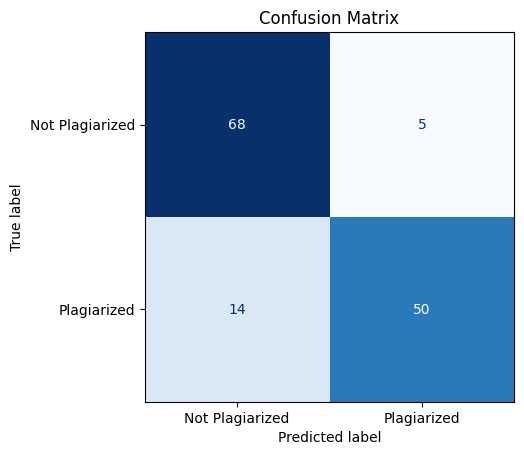

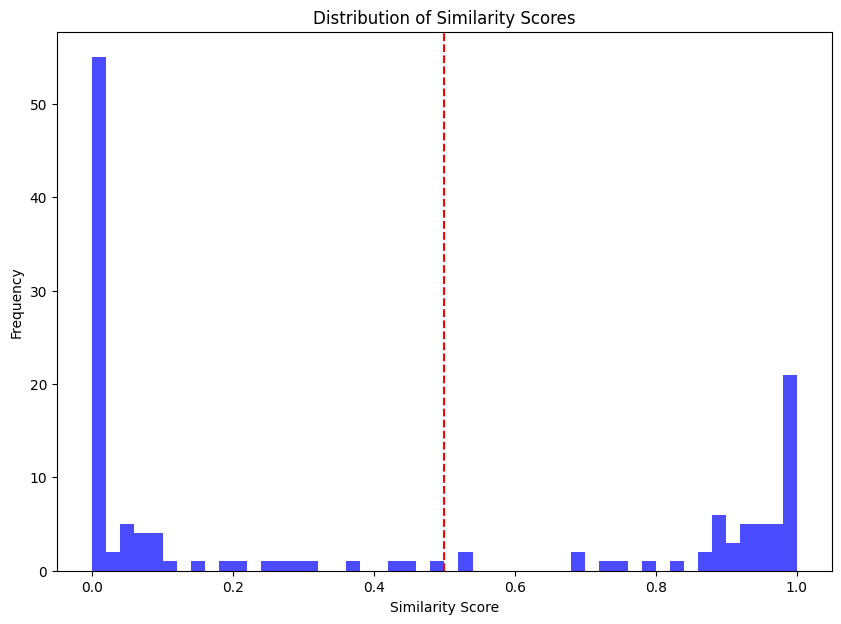

In [53]:
model.eval()
with torch.no_grad():
    test_X = torch.tensor(X_test).to(device)
    test_Y = torch.tensor(Y_test).to(device).unsqueeze(1)
    outputs = model(test_X)
    test_Y = test_Y.cpu().numpy().flatten()
    outputs = outputs.cpu().numpy().flatten()
    df_test = pd.DataFrame({"plagio": test_Y, "similarity": outputs})

evaluate_model(df_test, threshold=0.5)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       621
         1.0       0.99      0.99      0.99       475

    accuracy                           0.99      1096
   macro avg       0.99      0.99      0.99      1096
weighted avg       0.99      0.99      0.99      1096



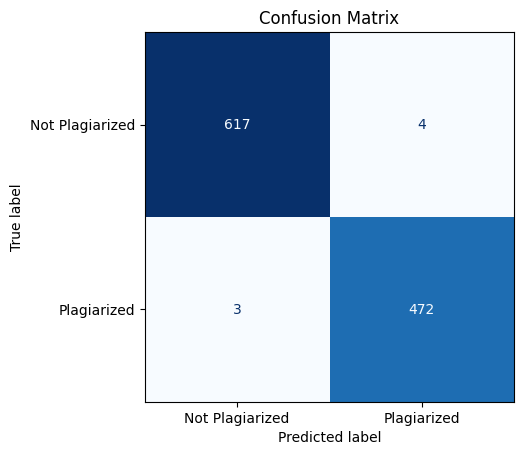

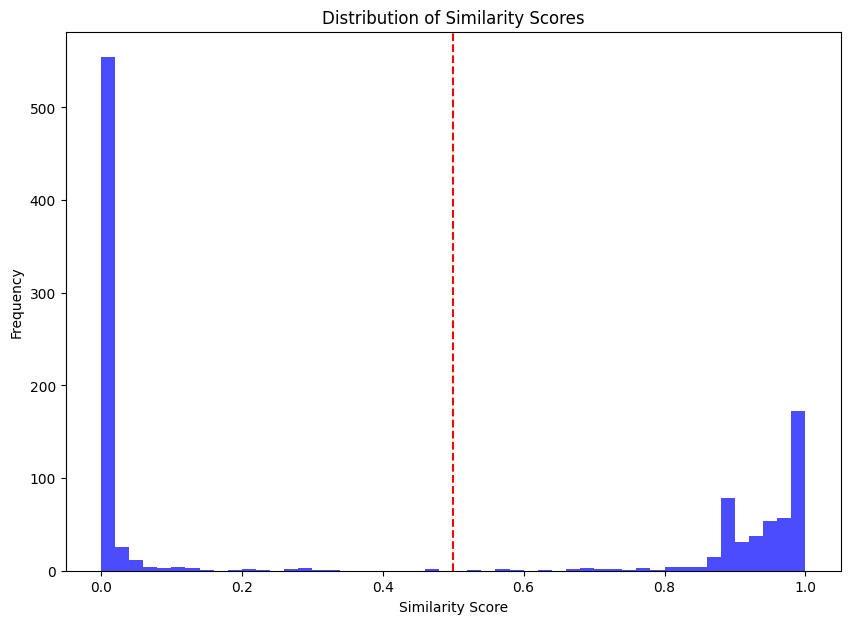

In [ ]:
model.eval()
with torch.no_grad():
    train_X = torch.tensor(X_train).to(device)
    train_Y = torch.tensor(Y_train).to(device).unsqueeze(1)
    
    outputs = model(train_X)
    train_Y = train_Y.cpu().numpy().flatten()
    outputs = outputs.cpu().numpy().flatten()
    df_train = pd.DataFrame({"plagio": train_Y, "similarity": outputs})

evaluate_model(df_train, threshold=0.5)